In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

In [3]:
#previously used data normalizer
#code to normalize weights to a range of -1 and 1
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler().fit_transform(data) * 2 - 1

In [4]:
#More functions needed for training
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [5]:
def fit_and_score(circuit_classifier, features, targets, random_state = 69069):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=1-3/4, random_state=random_state)

    plt.rcParams["figure.figsize"] = (12, 6)

    # fit classifier to data
    circuit_classifier.fit(X_train, y_train)
    score_train =  circuit_classifier.score(X_train, y_train)
    score_test =  circuit_classifier.score(X_test, y_test)
    print("Mean Accuracy traingin: " + str(score_train))
    print("Mean Accuracy testing: " + str(score_test))

    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # score classifier
    score =  circuit_classifier.score(features, targets)
    print('Mean Accuracy overall: ' + str(score))

In [6]:
dataset = load_iris()
data = dataset['data']
targets = np.array(dataset['target'])

quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

data = np.array(normalize_data(data))

In [7]:
data.shape[0]

150

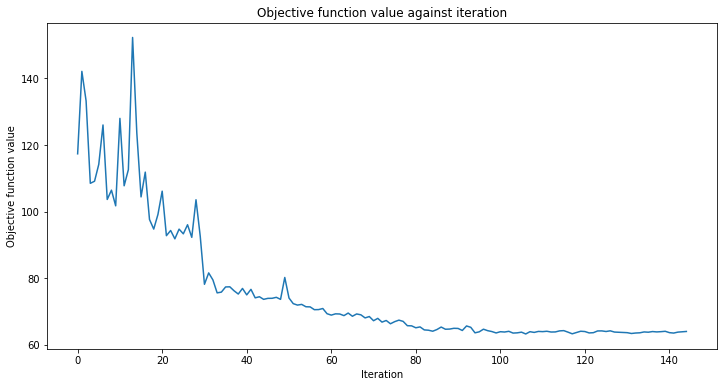

In [8]:
#building the circuit that got ~0.89 accuracy
#we need to update the parity function to resemble 3 classes
output_shape = 3  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % 3


feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)
for i in range(len(data[1])):
    ansatz.ry(Parameter('w_' + str(i+4)),i)
    ansatz.cry(Parameter('w_' + str(10+i+4)), i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuit_qnn = CircuitQNN(circuit=qc,    
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             #Warm start needed to not start from 0
                                             warm_start=True,
                                             callback=callback_graph)



# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
accuracy_iteration_vals = []
# compare 
fit_and_score(circuit_classifier, data, targets)

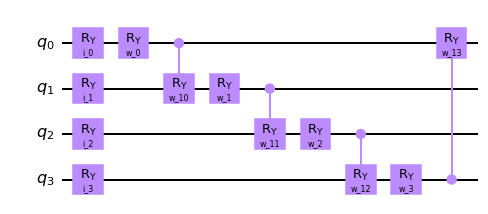

In [ ]:
qc.decompose().draw('mpl')

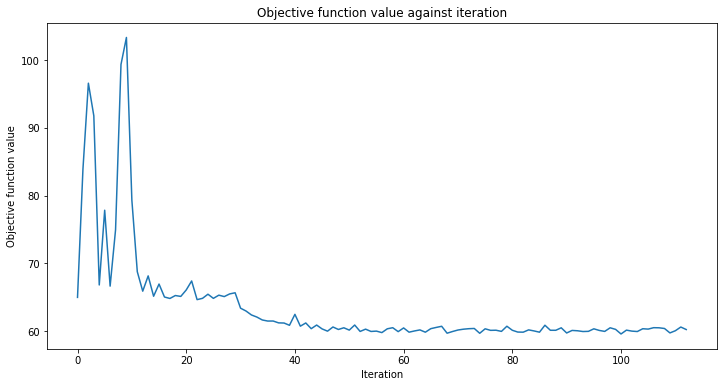

Mean Accuracy traingin: 0.8660714285714286
Mean Accuracy testing: 0.8421052631578947
Mean Accuracy overall: 0.84


In [ ]:
#Let's now retrain using another random test/train split
objective_func_vals = []
fit_and_score(circuit_classifier, data, targets, random_state=43792)

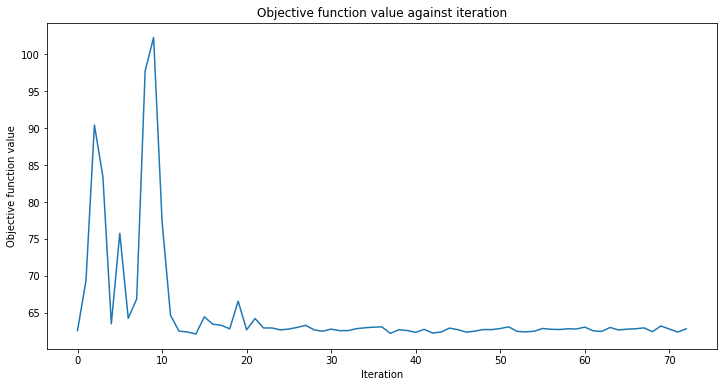

Mean Accuracy traingin: 0.7589285714285714
Mean Accuracy testing: 0.7368421052631579
Mean Accuracy overall: 0.76


In [ ]:
#Let's now retrain using another random test/train split
objective_func_vals = []
fit_and_score(circuit_classifier, data, targets, random_state=17609)

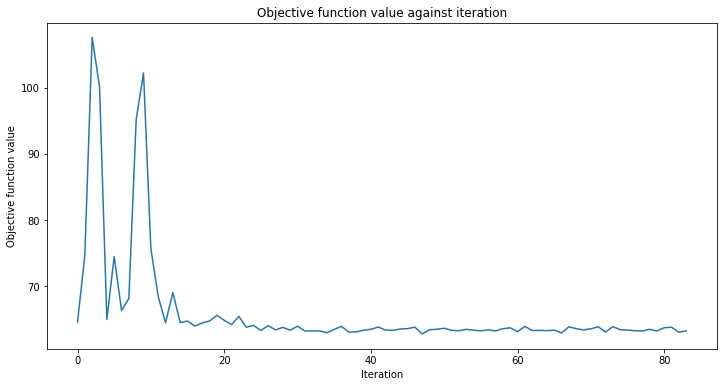

Mean Accuracy traingin: 0.6964285714285714
Mean Accuracy testing: 0.7631578947368421
Mean Accuracy overall: 0.7


In [ ]:
#Let's now retrain using another random test/train split
objective_func_vals = []
fit_and_score(circuit_classifier, data, targets, random_state=42069)

In [ ]:
from qiskit.opflow import Gradient, CircuitSampler, StateFn, OpflowError
from qiskit.opflow.expectations.pauli_expectation import PauliExpectation

test_qc = QuantumCircuit(2)
test_qc.ry(Parameter('i0'), 0)
test_qc.ry(Parameter('i1'), 1)
test_qc.ry(Parameter('w0'), 0)
test_qc.cry(Parameter('w01'), 0, 1)
test_qc.ry(Parameter('w1'), 1)
test_qc.cry(Parameter('w10'), 1, 0)

display(print(test_qc.decompose()))
expec_op  = PauliExpectation(group_paulis=False).convert(test_qc)
display(print(expec_op.decompose()))
display(print(expec_op.decompose()))
display(print(Gradient().convert(StateFn(test_qc))))
display(print((Gradient().convert(StateFn(test_qc)).coeff)))


     ┌───────────┐┌───────────┐                          ┌───────────┐┌───┐»
q_0: ┤ R(i0,π/2) ├┤ R(w0,π/2) ├──■────────────────────■──┤ Ry(w10/2) ├┤ X ├»
     ├───────────┤├───────────┤┌─┴─┐┌──────────────┐┌─┴─┐├───────────┤└─┬─┘»
q_1: ┤ R(i1,π/2) ├┤ Ry(w01/2) ├┤ X ├┤ Ry(-0.5*w01) ├┤ X ├┤ R(w1,π/2) ├──■──»
     └───────────┘└───────────┘└───┘└──────────────┘└───┘└───────────┘     »
«     ┌──────────────┐┌───┐
«q_0: ┤ Ry(-0.5*w10) ├┤ X ├
«     └──────────────┘└─┬─┘
«q_1: ──────────────────■──
«                          


None

     ┌───────────┐┌───────────┐                          ┌───────────┐┌───┐»
q_0: ┤ R(i0,π/2) ├┤ R(w0,π/2) ├──■────────────────────■──┤ Ry(w10/2) ├┤ X ├»
     ├───────────┤├───────────┤┌─┴─┐┌──────────────┐┌─┴─┐├───────────┤└─┬─┘»
q_1: ┤ R(i1,π/2) ├┤ Ry(w01/2) ├┤ X ├┤ Ry(-0.5*w01) ├┤ X ├┤ R(w1,π/2) ├──■──»
     └───────────┘└───────────┘└───┘└──────────────┘└───┘└───────────┘     »
«     ┌──────────────┐┌───┐
«q_0: ┤ Ry(-0.5*w10) ├┤ X ├
«     └──────────────┘└─┬─┘
«q_1: ──────────────────■──
«                          


None

     ┌───────────┐┌───────────┐                          ┌───────────┐┌───┐»
q_0: ┤ R(i0,π/2) ├┤ R(w0,π/2) ├──■────────────────────■──┤ Ry(w10/2) ├┤ X ├»
     ├───────────┤├───────────┤┌─┴─┐┌──────────────┐┌─┴─┐├───────────┤└─┬─┘»
q_1: ┤ R(i1,π/2) ├┤ Ry(w01/2) ├┤ X ├┤ Ry(-0.5*w01) ├┤ X ├┤ R(w1,π/2) ├──■──»
     └───────────┘└───────────┘└───┘└──────────────┘└───┘└───────────┘     »
«     ┌──────────────┐┌───┐
«q_0: ┤ Ry(-0.5*w10) ├┤ X ├
«     └──────────────┘└─┬─┘
«q_1: ──────────────────■──
«                          


None

ListOp([
  ListOp([
    CircuitStateFn(
         ┌──────────────────────────┐  ┌────────┐                           »
    q_0: ┤ Ry(i0 + 1.5707963267949) ├──┤ Ry(w0) ├───■────────────────────■──»
         └────────┬────────┬────────┘┌─┴────────┴┐┌─┴─┐┌──────────────┐┌─┴─┐»
    q_1: ─────────┤ Ry(i1) ├─────────┤ Ry(w01/2) ├┤ X ├┤ Ry(-0.5*w01) ├┤ X ├»
                  └────────┘         └───────────┘└───┘└──────────────┘└───┘»
    «     ┌───────────┐┌───┐┌──────────────┐┌───┐
    «q_0: ┤ Ry(w10/2) ├┤ X ├┤ Ry(-0.5*w10) ├┤ X ├
    «     └─┬────────┬┘└─┬─┘└──────────────┘└─┬─┘
    «q_1: ──┤ Ry(w1) ├───■────────────────────■──
    «       └────────┘                           
    ),
    CircuitStateFn(
         ┌──────────────────────────┐  ┌────────┐                           »
    q_0: ┤ Ry(i0 - 1.5707963267949) ├──┤ Ry(w0) ├───■────────────────────■──»
         └────────┬────────┬────────┘┌─┴────────┴┐┌─┴─┐┌──────────────┐┌─┴─┐»
    q_1: ─────────┤ Ry(i1) ├─────────┤ Ry(w01/2) ├┤ X ├┤ Ry

None

1.0


None